### Programming Assignment 2 for the course ES331 - Probability and Random Processes
#### Submitted by S Deepak Narayanan, 16110142, Computer Science and Engineering, IIT Gandhinagar

In [1]:
"""
    This cell is the Notebook is used for all the standard
    in-built modules that are pre-existing in Python. I am
    making use of Numerical Python (NumPy), MatPlotLib for 
    displaying images, cv2 for OpenCV
"""
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from numpy.fft import fft2, ifft2
from skimage.measure import compare_psnr

In [2]:
"""
    This Cell is majorly used for using all the functions that
    I define as a part of this program.
    ---------------------------------------------------------
    The Gaussian Filter is defined here. This is just
    the standard Gaussian Filter used to convolve with 
    images. I am simulating defocus blur using this Filter.
    I am explictly making a Gaussian because I need a kernel 
    that is a part of the Wiener Filter Setup to find a 
    new filter that'd be used for Convolution with the blurred
    and noisy image to get back the original image
"""
def gaussian_filter(size, std_dev):
    kernel = np.zeros((size,size))
    offset = size//2
    for i in range(size):
        for j in range(size):
            kernel[i][j] = np.exp(-((i-offset)**2 + (j-offset)**2)/(2*std_dev**2))
    return kernel/kernel.sum()

"""
    The standard function for blurring the image is below.
    1. Note that the entire process of convolution is done in the 
    Frequency Domain.
    2. I am moving from the space domain to the frequency domain 
    here for the input image and the kernel. I retreive the blurred 
    image in the space domain by doing an Inverse Time Fourier Transform.
    3. Do note the normalization below. I am converting the image values to
    have values between 0 and 1, only. This is to esentially ensure that 
    there is no numerical blowup. I am completely performing all the operations 
    in floating points, only.
"""

def blur_image(image,kernel):
    blur = np.zeros(image.shape) 
    temp_image = np.float32(image)
    temp_image/=255
    temp_image= np.clip(temp_image,0,1)                   # Below, there's a loop - This runs thrice, once each for channels R,G,B.
    for i in range(3): 
        img_freq = fft2(temp_image[:,:,i])                # Transformation here.
        ker_freq = fft2(kernel,temp_image.shape[:2])
        blr_freq = img_freq*ker_freq                      # Convolution has become multiplication
        blur_inv = np.real(ifft2(blr_freq))               # Only taking the Real Part - there could potentially be imaginary parts.
        blur[:,:,i] = blur_inv                            # Channel Wise Computation
    return blur

"""
    The function on additive noise in essence just adds
    the additive noise, sampled from a gaussian whose
    default mean and standard deviation used are 0 and 0.0001.
    For varying standard deviations, results are attached in the report.
"""

def additive_noise(blur,std):
    noise = np.random.normal(0,std,blur.shape)         # Gaussian Noise - Sampled from distribution
    noisy_image = blur+noise                              # Addition - The reason for being called "additive"
    return noisy_image,noise                              
"""
    The below code is for the implementation of the Wiener Filter
    in itself totality. I do this process also channel wise, similar
    to how I initially blurred the image. Also, each of the blurred image,
    the noise, are all transormed to the frequency domain and then are
    substituted in the Wiener Equation below. Then again, only the real
    part is taken into consideration. 
"""

def wiener_filter(noisy,kernel,noise):
    filter_final = np.zeros(noisy.shape,dtype = complex)
    final_image = np.zeros(noisy.shape)
    for i in range(3):
        img_freq = fft2(noisy[:,:,i])                           # Getting the channel from the noisy image - blur + noise
        ker_freq = fft2(kernel,img_freq.shape)                  # Kernel is transformed into the frequency domain.
        nse_freq = fft2(noise[:,:,i])                           # Noise is transformed into the frequency domain.
        ker_conj = np.conjugate(ker_freq)                       # We need the conjugate of the Kernel as per the Wiener Equation       
        wiener = (ker_conj*img_freq)/((ker_freq.real**2 + ker_freq.imag**2)*img_freq + nse_freq)  # The Wiener Filter Equation
        fin_ = ifft2(wiener*img_freq).real                      # Get back the real values 
        final_image[:,:,i] = fin_                               # Assign to corresponding Channel.
        filter_final[:,:,i] = wiener
    return final_image,filter_final

#### To change the value of the Sigma for Blurring and for Additive Noise,
1. Please change line 13 in the below cell for changing the sigma for additive noise.
2. Please change at line 14 in the cell below for changing the sigma for Gaussian Blurring.
3. Detailed results entail below. Do have a look at them before doing points 1. and 2. above.
4. Size of the Gaussian Kernel is set to 6 times sigma. This is to be able to cover the entire gaussian almost.

#### The below cell displays in detail, the entire process of filtering, from input image to the blurred image to the noisy image, to the deblurred restored image.

The PSNR Values for Image with Final Image, and Image with Noisy Image are
22.46514189133197 14.566275553820427


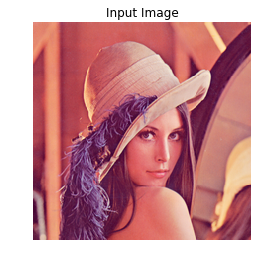

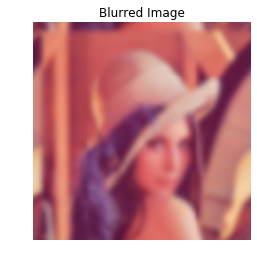

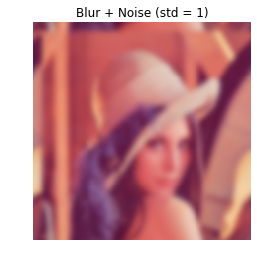

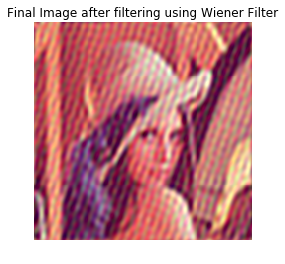

In [3]:
"""
    This part of the code is the main function that I have used.
    This is just for standard input and output. This automatically
    takes care of the running of the entire program. 
"""


image = cv.imread('lena.png')   # Read Input Image                                
image = (cv.cvtColor(image, cv.COLOR_BGR2RGB)) # OpenCV Reads in reverse order - change that 
plt.title('Input Image')
plt.axis('off')
plt.imshow(image) # Display Input Image
sigma = 0.0001 # Vary this sigma for variations in Gaussian Additive Noise
kernel = gaussian_filter(19,3)    # Filter Size ~ 6 sigma - Most of Gaussian should get covered # 1st parameter is size, 2nd is sigma
blurred = blur_image(image,kernel)    # blurring the image
noisy, noise = additive_noise(blurred,sigma)    # Noisy Image is obtained
final,wiener = wiener_filter(noisy,kernel,noise)     # Wiener filter gets us original image 
blurred = np.clip(blurred,0,1)            # Normalisation done here - It is done internally at blur stage
noisy = np.clip(noisy,0,1)                # Final Noisy Image values in the range 0 to 1
final = np.clip(final,0,1)               # Final Image
blurred = np.uint8(blurred*255)            # Blurred Image
noisy = np.uint8(noisy*255)                # Noisy Image
final = np.uint8(final*255)                # Final Image   
# Displaying the Images below
plt.figure()
plt.axis('off')
plt.title('Blurred Image')
plt.imshow(blurred)
plt.imsave('blurred.jpg',blurred)
plt.figure()
plt.title('Blur + Noise (std = 1)')
plt.axis('off')
plt.imshow(noisy)
plt.imsave('noisy.jpg',noisy)
plt.figure()
plt.title('Final Image after filtering using Wiener Filter')
plt.axis('off')
plt.imshow(final)
plt.imsave('final.jpg',final)
print('The PSNR Values for Image with Final Image, and Image with Noisy Image are')
print(compare_psnr(image,final),compare_psnr(image,noisy))


#### In the above cell, we've computed the Wiener Filter once for a given blur. Now, we shall use this for this given blur for all the images from now on.
1. The same Wiener Filter, for the same blur, is being run across different amounts of noise. Again, the filter is not getting recomputed again and again.
2. Also, we can see the trend in PSNR below. 
3. This is repeated below for standard deviation of the Gaussian Filter used to blur for values 1,3 and 5.
4. The Final Images for various values of sigma of additive noise are shown below.

### Blurring Standard Deviation = 1

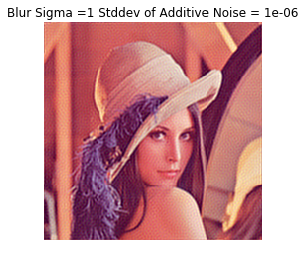

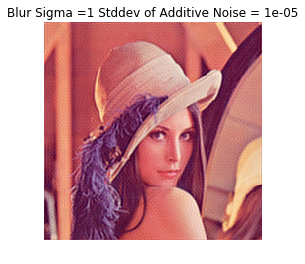

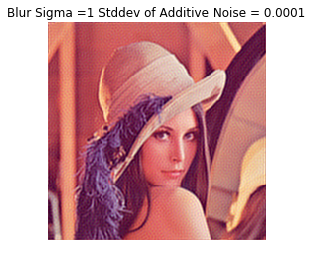

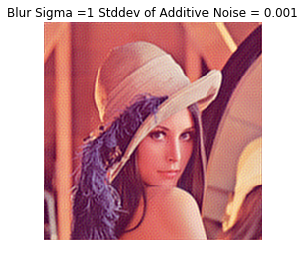

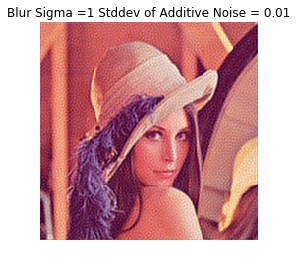

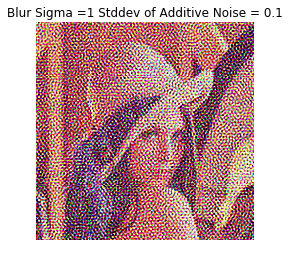

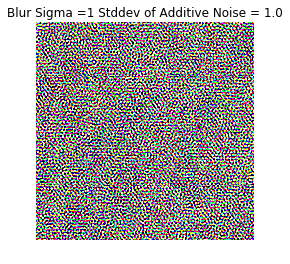

In [4]:
sigma = 0.0001 # Vary this sigma for variations in Gaussian Additive Noise
kernel = gaussian_filter(7,1)    # Filter Size ~ 6 sigma - Most of Gaussian should get covered # 1st parameter is size, 2nd is sigma
blurred = blur_image(image,kernel)    # blurring the image
noisy, noise = additive_noise(blurred,sigma)    # Noisy Image is obtained
final,wiener = wiener_filter(noisy,kernel,noise) 
stddev = []
psnr = []
psnr_n = []
sigma = 10**-6
while(sigma<=1.0):
    noisy, noise = additive_noise(blurred,sigma)           
    final_image = np.zeros(noisy.shape)
    for i in range(3):
        img_freq = fft2(noisy[:,:,i])
        fin_ = ifft2(wiener[:,:,i]*img_freq).real 
        final_image[:,:,i] = fin_
    final_image = np.clip(final_image,0,1) 
    final_image = np.uint8(final_image*255) 
    plt.figure()
    plt.axis('off')
    plt.title('Blur Sigma ='+str(1)+' Stddev of Additive Noise = '+str(str(np.round(sigma,7))))
    plt.imshow(final_image)
    stddev.append(str(np.round(sigma,7)))
    psnr.append(compare_psnr(final_image,image))
    noisy = np.clip(noisy,0,1) 
    noisy = np.uint8(255*noisy)
    psnr_n.append(compare_psnr(noisy,image))
    sigma*=10

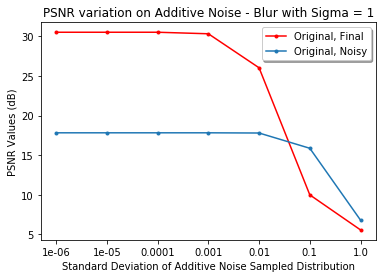

In [5]:
plt.title('PSNR variation on Additive Noise - Blur with Sigma = 1')
plt.xlabel('Standard Deviation of Additive Noise Sampled Distribution')
plt.ylabel('PSNR Values (dB)')
plt.plot(stddev,psnr,marker = '.',color='red',label='Original, Final')
plt.plot(stddev,psnr_n,marker = '.',label = 'Original, Noisy')
plt.legend(loc='best',shadow='True')

### Blurrinf Standard Deviation = 3

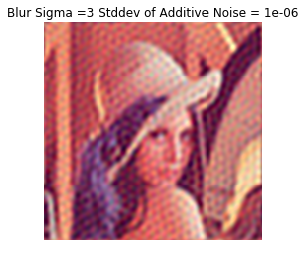

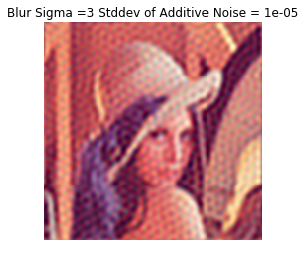

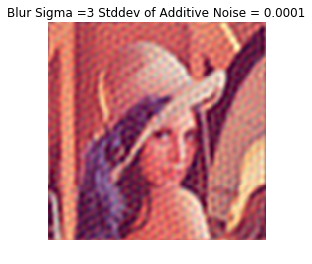

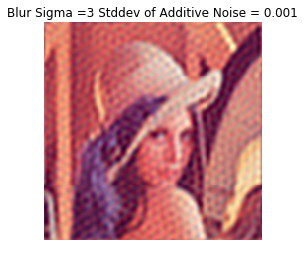

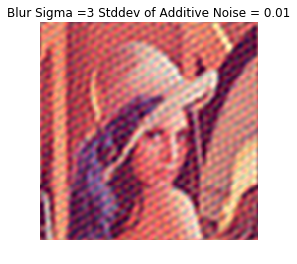

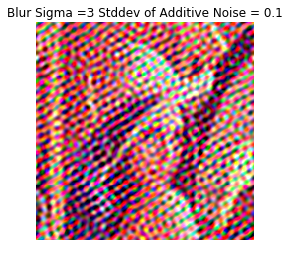

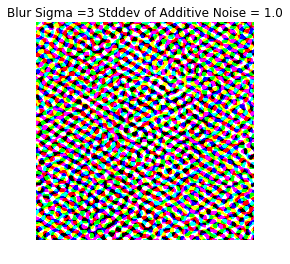

In [6]:
sigma = 0.0001 # Vary this sigma for variations in Gaussian Additive Noise
kernel = gaussian_filter(19,3)    # Filter Size ~ 6 sigma - Most of Gaussian should get covered # 1st parameter is size, 2nd is sigma
blurred = blur_image(image,kernel)    # blurring the image
noisy, noise = additive_noise(blurred,sigma)    # Noisy Image is obtained
final,wiener = wiener_filter(noisy,kernel,noise) 
stddev = []
psnr = []
psnr_n = []
sigma = 10**-6
kernel = gaussian_filter(19,3) 
while(sigma<=1.0):
    blurred = blur_image(image,kernel)
    noisy, noise = additive_noise(blurred,sigma)           
    final_image = np.zeros(noisy.shape)
    for i in range(3):
        img_freq = fft2(noisy[:,:,i])
        fin_ = ifft2(wiener[:,:,i]*img_freq).real 
        final_image[:,:,i] = fin_
    final_image = np.clip(final_image,0,1) 
    final_image = np.uint8(final_image*255) 
    plt.figure()
    plt.axis('off')
    plt.title('Blur Sigma ='+str(3)+' Stddev of Additive Noise = '+str(str(np.round(sigma,7))))
    plt.imshow(final_image)
    stddev.append(str(np.round(sigma,7)))
    psnr.append(compare_psnr(final_image,image))
    noisy = np.clip(noisy,0,1) 
    noisy = np.uint8(255*noisy)
    psnr_n.append(compare_psnr(noisy,image))
    sigma*=10

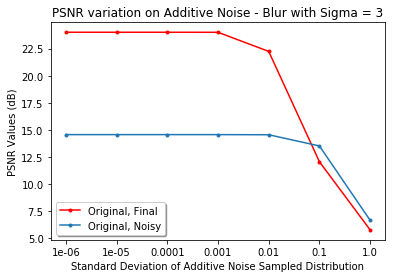

In [7]:
plt.title('PSNR variation on Additive Noise - Blur with Sigma = 3')
plt.xlabel('Standard Deviation of Additive Noise Sampled Distribution')
plt.ylabel('PSNR Values (dB)')
plt.plot(stddev,psnr,marker = '.',color='red',label='Original, Final')
plt.plot(stddev,psnr_n,marker = '.',label = 'Original, Noisy')
plt.legend(loc='best',shadow='True')

### Blurring Standard Deviation = 3.5

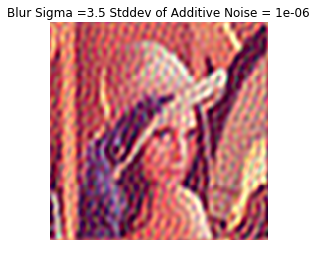

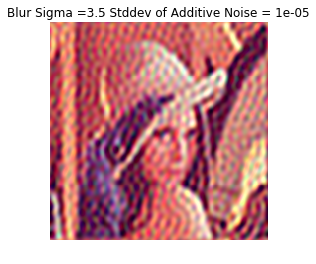

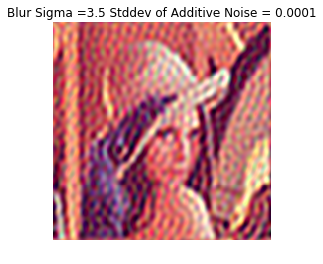

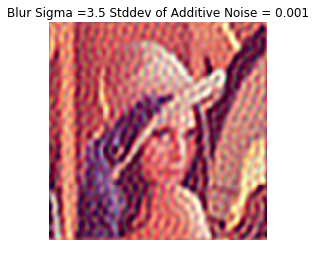

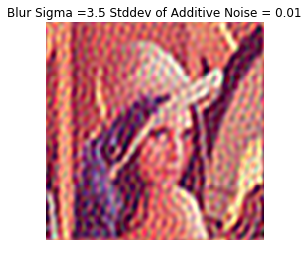

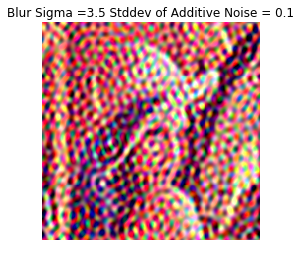

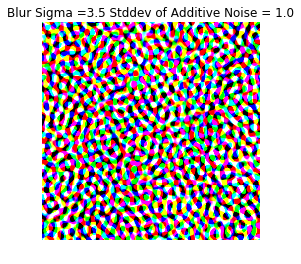

In [8]:
sigma = 0.0001 # Vary this sigma for variations in Gaussian Additive Noise
kernel = gaussian_filter(21,3.5)    # Filter Size ~ 6 sigma - Most of Gaussian should get covered # 1st parameter is size, 2nd is sigma
blurred = blur_image(image,kernel)    # blurring the image
noisy, noise = additive_noise(blurred,sigma)    # Noisy Image is obtained
final,wiener = wiener_filter(noisy,kernel,noise) 
stddev = []
psnr = []
psnr_n = []
sigma = 10**-6
kernel = gaussian_filter(19,3) 
while(sigma<=1.0):
    blurred = blur_image(image,kernel)
    noisy, noise = additive_noise(blurred,sigma)           
    final_image = np.zeros(noisy.shape)
    for i in range(3):
        img_freq = fft2(noisy[:,:,i])
        fin_ = ifft2(wiener[:,:,i]*img_freq).real 
        final_image[:,:,i] = fin_
    final_image = np.clip(final_image,0,1) 
    final_image = np.uint8(final_image*255) 
    plt.figure()
    plt.axis('off')
    plt.title('Blur Sigma ='+str(3.5)+' Stddev of Additive Noise = '+str(str(np.round(sigma,7))))
    plt.imshow(final_image)
    stddev.append(str(np.round(sigma,7)))
    psnr.append(compare_psnr(final_image,image))
    noisy = np.clip(noisy,0,1) 
    noisy = np.uint8(255*noisy)
    psnr_n.append(compare_psnr(noisy,image))
    sigma*=10

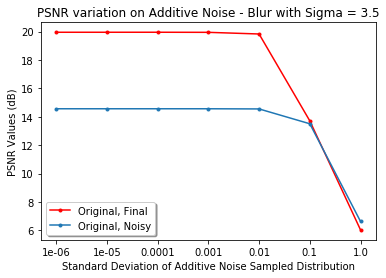

In [9]:
plt.title('PSNR variation on Additive Noise - Blur with Sigma = 3.5')
plt.xlabel('Standard Deviation of Additive Noise Sampled Distribution')
plt.ylabel('PSNR Values (dB)')
plt.plot(stddev,psnr,marker = '.',color='red',label='Original, Final')
plt.plot(stddev,psnr_n,marker = '.',label = 'Original, Noisy')
plt.legend(loc='best',shadow='True')

### Blurring Standard Deviation = 5

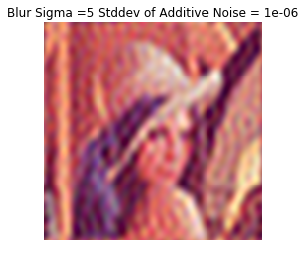

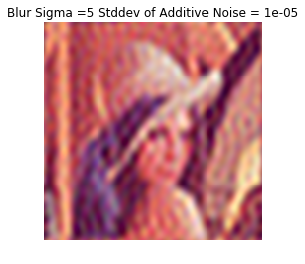

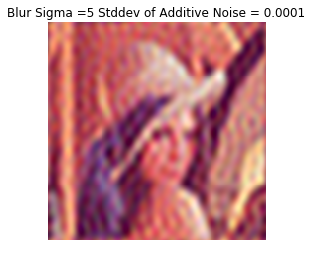

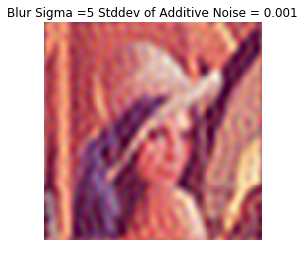

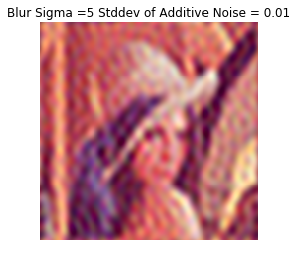

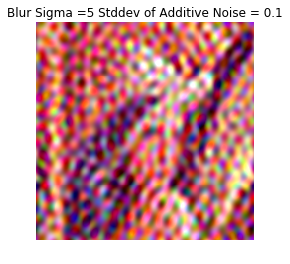

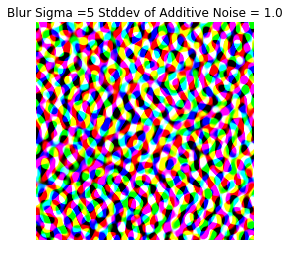

In [10]:
sigma = 0.0001 # Vary this sigma for variations in Gaussian Additive Noise
kernel = gaussian_filter(31,5)    # Filter Size ~ 6 sigma - Most of Gaussian should get covered # 1st parameter is size, 2nd is sigma
blurred = blur_image(image,kernel)    # blurring the image
noisy, noise = additive_noise(blurred,sigma)    # Noisy Image is obtained
final,wiener = wiener_filter(noisy,kernel,noise) 
stddev = []
psnr = []
psnr_n = []
sigma = 10**-6
while(sigma<=1.0):
    blurred = blur_image(image,kernel)
    noisy, noise = additive_noise(blurred,sigma)           
    final_image = np.zeros(noisy.shape)
    for i in range(3):
        img_freq = fft2(noisy[:,:,i])
        fin_ = ifft2(wiener[:,:,i]*img_freq).real 
        final_image[:,:,i] = fin_
    final_image = np.clip(final_image,0,1) 
    final_image = np.uint8(final_image*255) 
    plt.figure()
    plt.axis('off')
    plt.title('Blur Sigma ='+str(5)+' Stddev of Additive Noise = '+str(str(np.round(sigma,7))))
    plt.imshow(final_image)
    plt.imshow(final_image)
    stddev.append(str(np.round(sigma,7)))
    psnr.append(compare_psnr(final_image,image))
    noisy = np.clip(noisy,0,1) 
    noisy = np.uint8(255*noisy)
    psnr_n.append(compare_psnr(noisy,image))
    sigma*=10

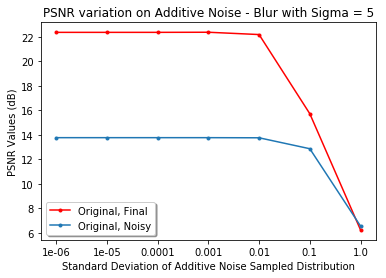

In [11]:
plt.title('PSNR variation on Additive Noise - Blur with Sigma = 5')
plt.xlabel('Standard Deviation of Additive Noise Sampled Distribution')
plt.ylabel('PSNR Values (dB)')
plt.plot(stddev,psnr,marker = '.',color='red',label='Original, Final')
plt.plot(stddev,psnr_n,marker = '.',label = 'Original, Noisy')
plt.legend(loc='best',shadow='True')

### PSNR Values Comparison
1. For standard deviation of a given value, the value of the additive gaussian noise is varied from 0.000001 to 
    * The corresponding PSNR values for the (Input,Blurred), and (Input,Final) pairs were computed. The results are as below. 
    * Also, do note that the filter size is fixed, once the standard deviation is fixed. It is taken to be approximately 6 times sigma so that roughly 95 % of the Gaussian is covered inside our filter.
    * We compute the Wiener Filter only once, for a given blurring sigma. This is crucial in our evaluation.